<a href="https://colab.research.google.com/github/mohanrajmit/Autoencoder/blob/master/plain_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np


In [2]:
def build(width, height, depth, filters=(32, 64), latentDim=16):
  # initialize the input shape to be "channels last" along with
  # the channels dimension itself
  # channels dimension itself
  inputShape = (height, width, depth)
  chanDim = -1
  # define the input to the encoder
  inputs = Input(shape=inputShape)
  x = inputs
  # loop over the number of filters
  for f in filters:
    # apply a CONV => RELU => BN operation
    x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=chanDim)(x)
  # flatten the network and then construct our latent vector
  volumeSize = K.int_shape(x)
  x = Flatten()(x)
  latent = Dense(latentDim)(x)
  # build the encoder model
  encoder = Model(inputs, latent, name="encoder")#encoder.summary()
  # start building the decoder model which will accept the
  # output of the encoder as its inputs
  latentInputs = Input(shape=(latentDim,))
  x = Dense(np.prod(volumeSize[1:]))(latentInputs)
  x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
  # loop over our number of filters again, but this time in
  # reverse order
  for f in filters[::-1]:
    # apply a CONV_TRANSPOSE => RELU => BN operation
    x = Conv2DTranspose(f, (3, 3), strides=2,
      padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=chanDim)(x)
    # apply a single CONV_TRANSPOSE layer used to recover the
  # original depth of the image
  x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
  outputs = Activation("sigmoid")(x)
  # build the decoder model
  decoder = Model(latentInputs, outputs, name="decoder")
  # our autoencoder is the encoder + decoder
  autoencoder = Model(inputs, decoder(encoder(inputs)),name="autoencoder")
  # return a 3-tuple of the encoder, decoder, and autoencoder
  return (encoder, decoder, autoencoder)

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...
11501568/11490434 [==============================] - 0s 0us/step


In [5]:
#construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)


[INFO] building autoencoder...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                69392     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         109377    
                                                                 
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________


In [7]:
# train the convolutional autoencoder
H = autoencoder.fit(trainX, trainX,validation_data=(testX, testX),epochs=EPOCHS,batch_size=BS)

Epoch 1/25
1875/1875 [==============================] - 20s 4ms/step - loss: 0.0185 - val_loss: 0.0107
Epoch 2/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0104 - val_loss: 0.0096
Epoch 3/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0094 - val_loss: 0.0096
Epoch 4/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 5/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 6/25
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0081 - val_loss: 0.0090
Epoch 7/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 8/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 9/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 10/25
1875/1875 [==============================] - 9s 5ms/step - loss: 

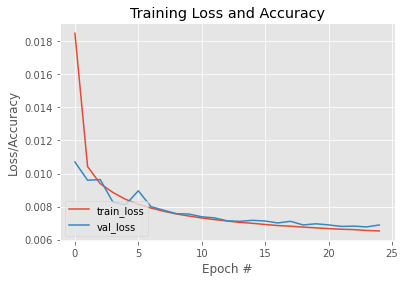

In [10]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig("/content/loss.png")

In [11]:
# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
outputs = None
# loop over our number of output samples
for i in range(0, 10):
	# grab the original image and reconstructed image
	original = (testX[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")
	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])
	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output
	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])
# save the outputs image to disk
cv2.imwrite("prediction.png", outputs)

[INFO] making predictions...


True